# Simplified-Workflow ver11

eyes open


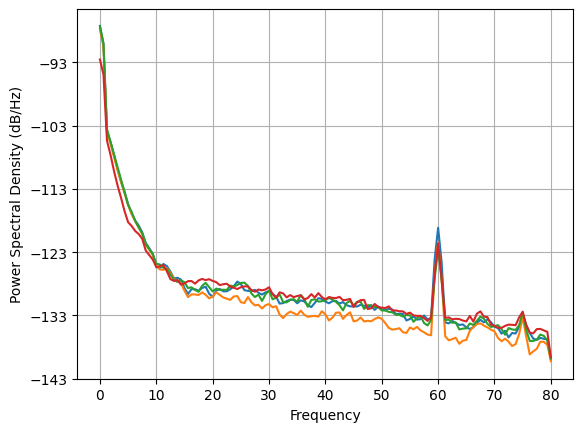

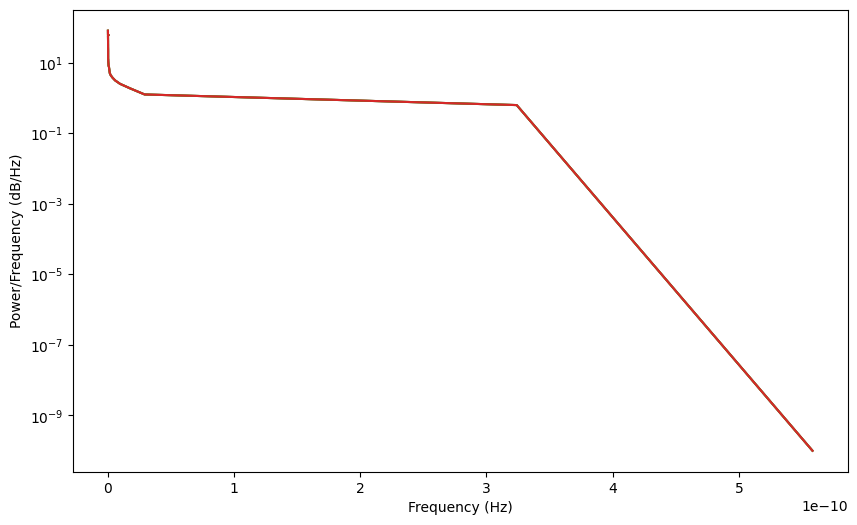

eyes closed


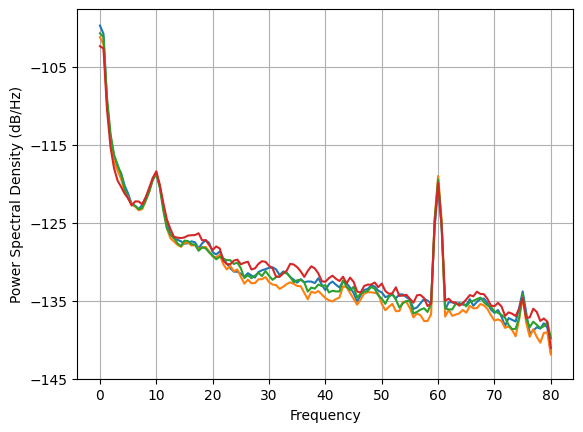

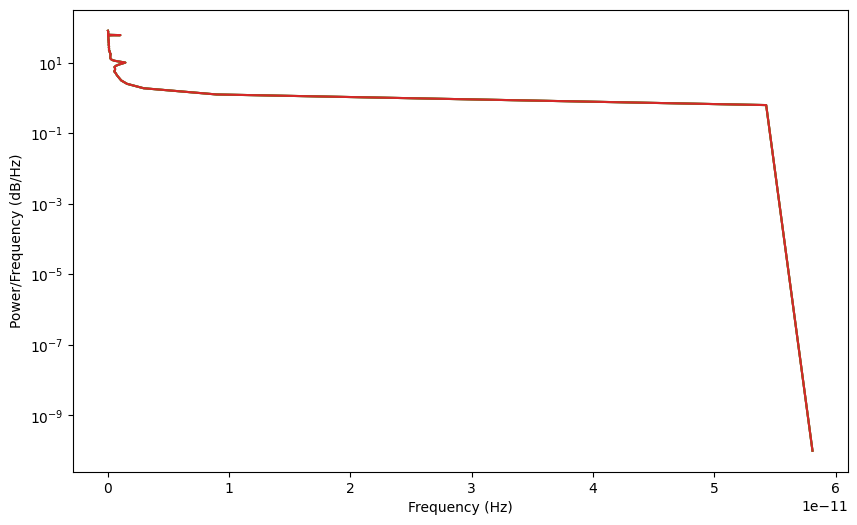

83


In [3]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.fft import rfft, irfft
from torch.nn.functional import normalize
from scipy.signal import welch
from scipy import signal


NUM_CHANNELS = 4
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=256, noverlap=128, window=np.hanning(256), scale_by_freq=True)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd

def average_across_arrays(generated_data):
    return generated_data.mean(dim=0)

# Set the sampling frequency
fs = 160.0

## open data
# averaged_data = average_across_arrays(torch.tensor(training_data_open).detach())
# freqs, psd = compute_psd(averaged_data, fs)
# plt.figure(figsize=(10, 6))  # Add this line to create a single figure
# for ch_idx in range(NUM_CHANNELS):
#     plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

# print("eyes open")
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.show()



# ## closed data
# averaged_data = average_across_arrays(torch.tensor(training_data_closed).detach())
# freqs, psd = compute_psd(averaged_data, fs)
# plt.figure(figsize=(10, 6))  # Add this line to create a single figure
# for ch_idx in range(NUM_CHANNELS):
#     plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

# print("eyes closed")
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.show()


def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def plot_everything(generated_data, gen_err, critic_err):
    generated_data = generated_data.detach()
    
    # plotting generated data
    values = generated_data[0, 0, :]
    plt.plot(values.tolist())
    plt.show()

    # plotting PSD
    averaged_data = average_across_arrays(generated_data)
    freqs, psd = compute_psd(averaged_data, fs)
    plt.figure(figsize=(10, 6))  # Add this line to create a single figure
    for ch_idx in range(NUM_CHANNELS):
        plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # plotting G vs D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_err,label="Generator")
    plt.plot(critic_err,label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(200, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(200, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(200, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(200, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(200, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(200, NUM_CHANNELS, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(NUM_CHANNELS, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(NUM_CHANNELS, 200, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(200, 200, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(200, NUM_CHANNELS, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

# 83 batch size for eyes_open
# 76 batch size for eyes_closed

# Fourier transformation D only

Epoch 0: Critic error ([15656.52517951649]) Generator err ([0.027550339698791504])
Epoch 0: Critic PSD error ([15651.605056152996])


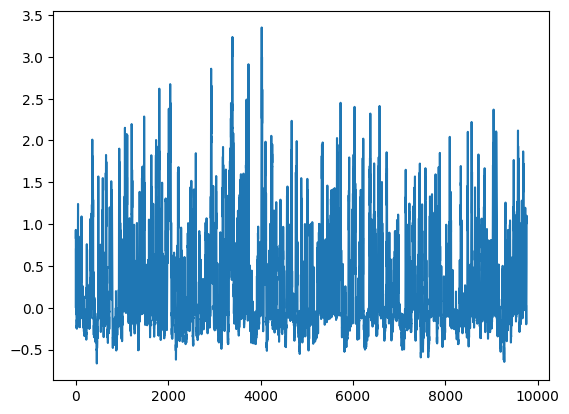

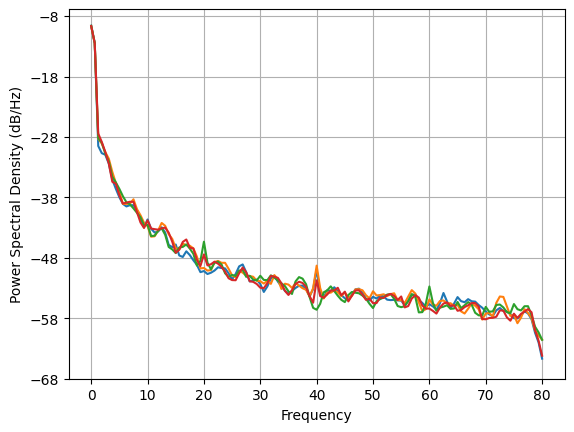

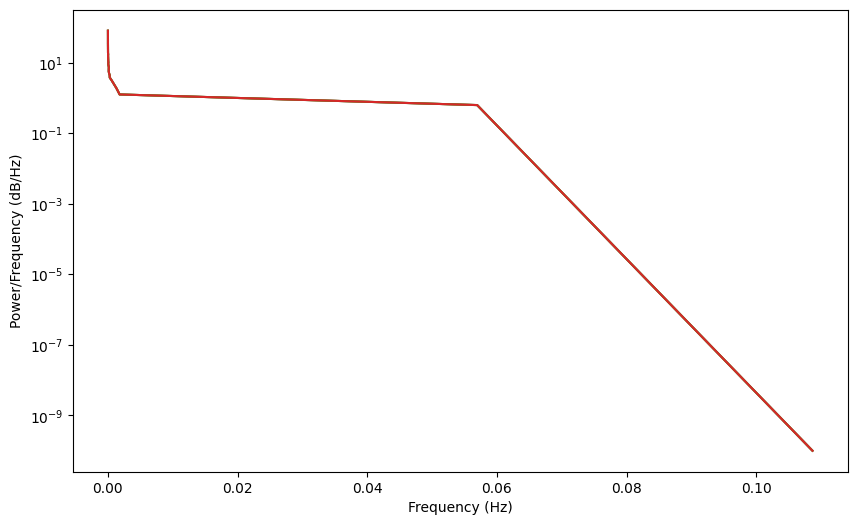

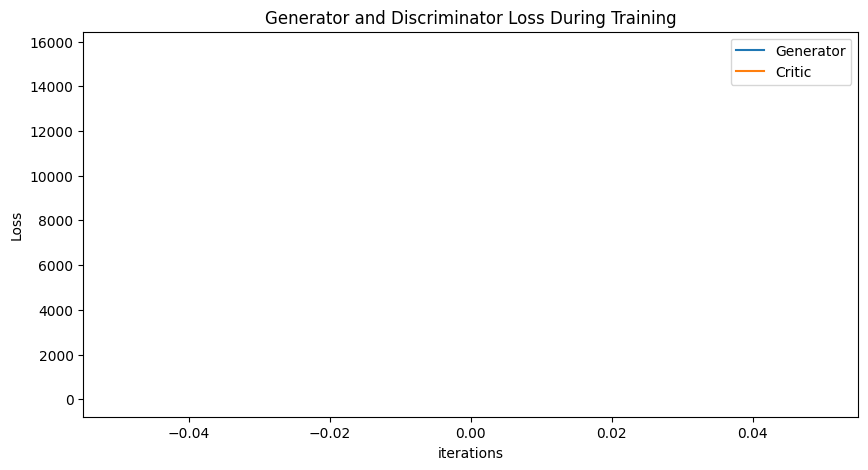

Epoch 10: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647]) Generator err ([0.027550339698791504, 0.030276959761977196, 0.029685450717806816, 0.005940358620136976, -0.02454068325459957, -0.1495654135942459, -0.19558824598789215, -0.513938307762146, -0.6868963837623596, -1.1229338645935059, -1.0189263820648193])
Epoch 10: Critic PSD error ([15651.605056152996, 15645.680513603009, 15094.869111304704, 15303.826194809442, 16377.561176863355, 16869.924173989835, 17036.734909971332, 18250.066054212268, 19246.517424174177, 18555.54040491268, 18437.309913384674])


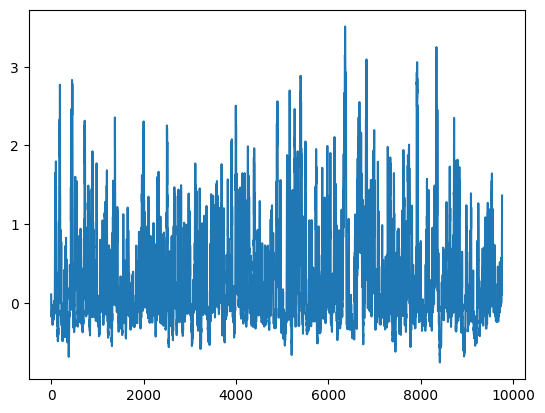

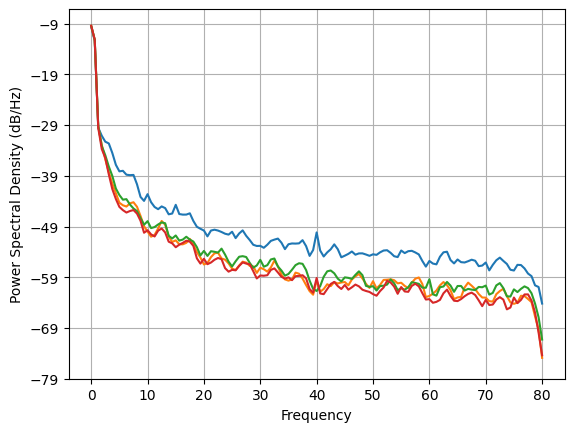

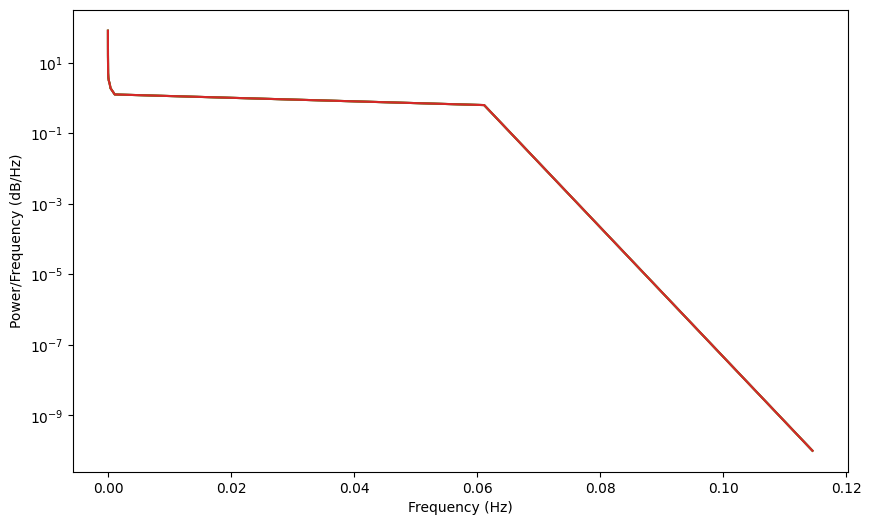

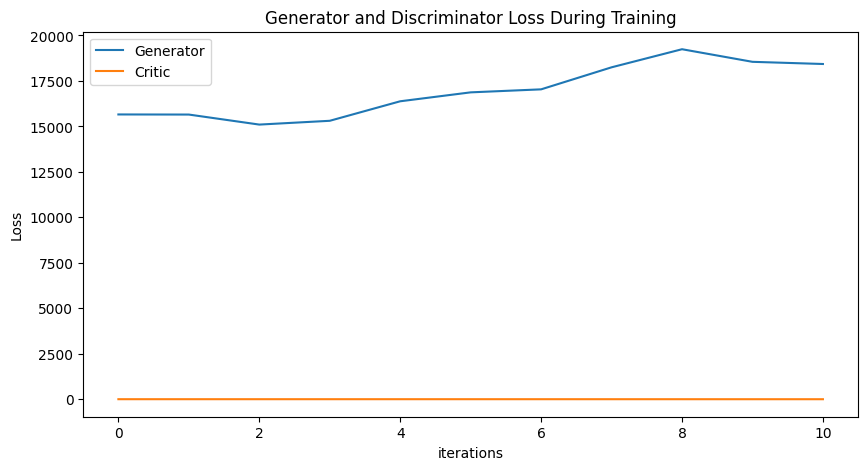

Epoch 20: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918]) Generator err ([0.027550339698791504, 0.030276959761977196, 0.029685450717806816, 0.005940358620136976, -0.02454068325459957, -0.1495654135942459, -0.19558824598789215, -0.513938307762146, -0.6868963837623596, -1.1229338645935059, -1.0189263820648193, -1.6096771955490112, -1.9418363571166992, -2.2445521354675293, -2.309713840484619, -3.882028341293335, -5.3593621253967285, -5.928407669067383, -9.513816833496094, -11.348617553710938, -14.369034767150879])
Epoch 20: Critic PSD error ([15651.605056152996, 15645.680513603009, 15094.869111304704, 15303.826194

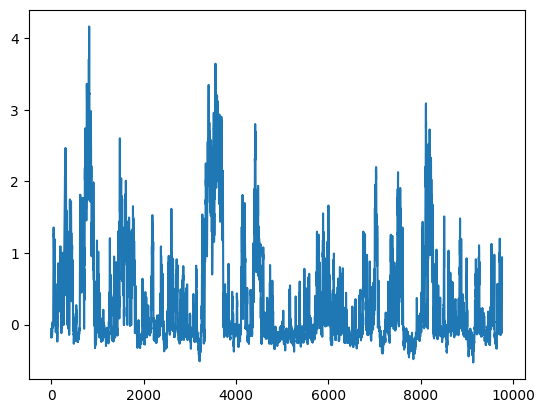

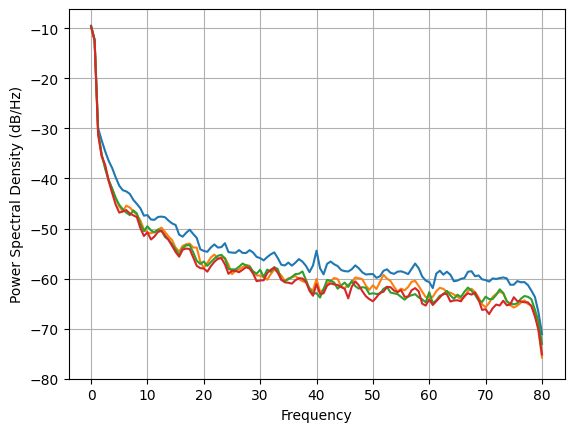

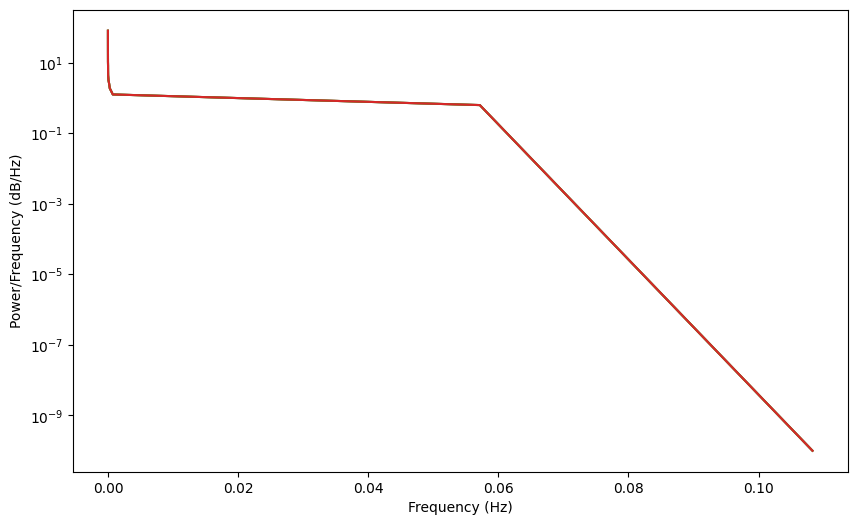

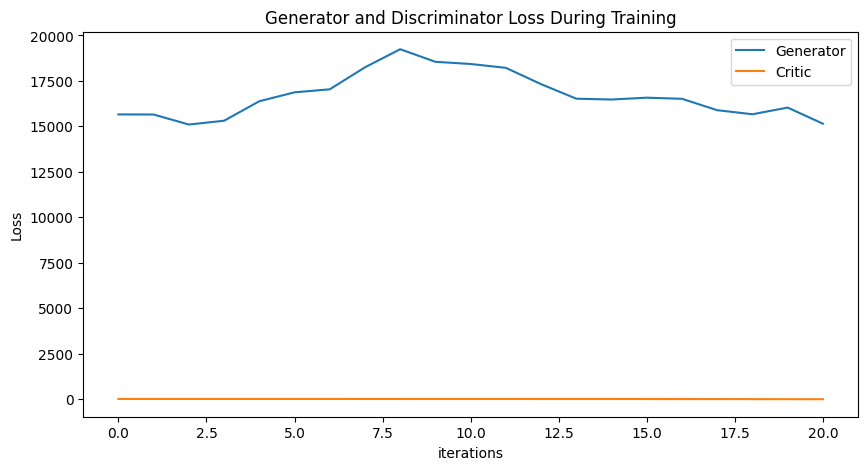

Epoch 30: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176]) Generator err ([0.027550339698791504, 0.030276959761977196, 0.029685450717806816, 0.005940358620136976, -0.02454068325459957, -0.1495654135942459, -0.19558824598789215, -0.513938307762146, -0.6868963837623596, -1.1229338645935059, -1.0189263820648193, -1.6096771955490112, -1.9418363571166992, -2.2445521354675293, -2.309713840484619, -3.882028341293335, -5.359362125

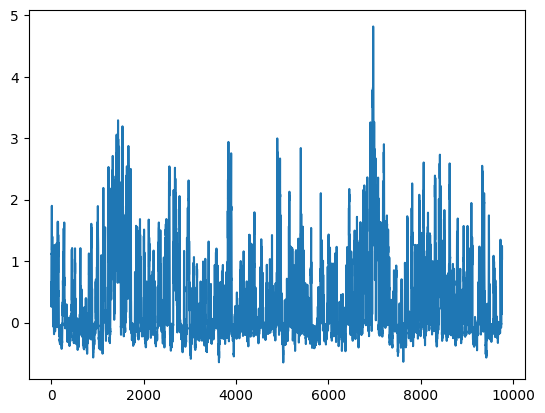

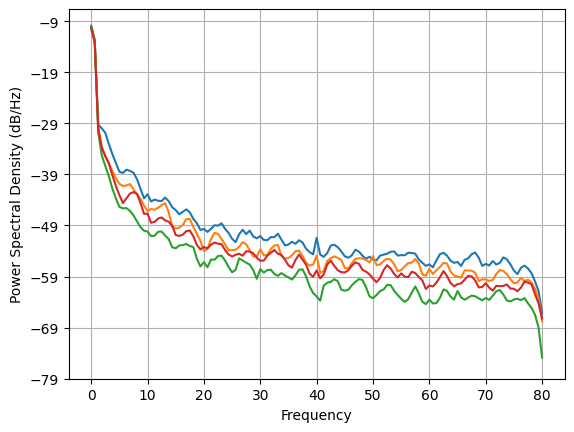

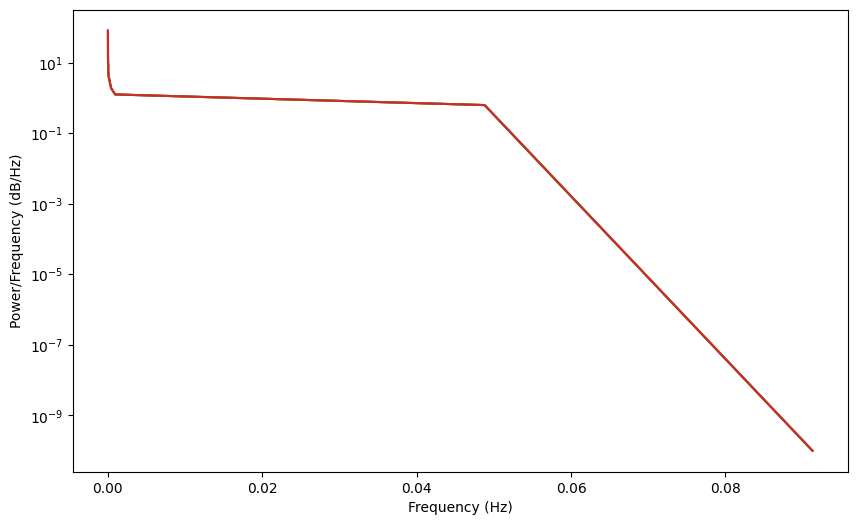

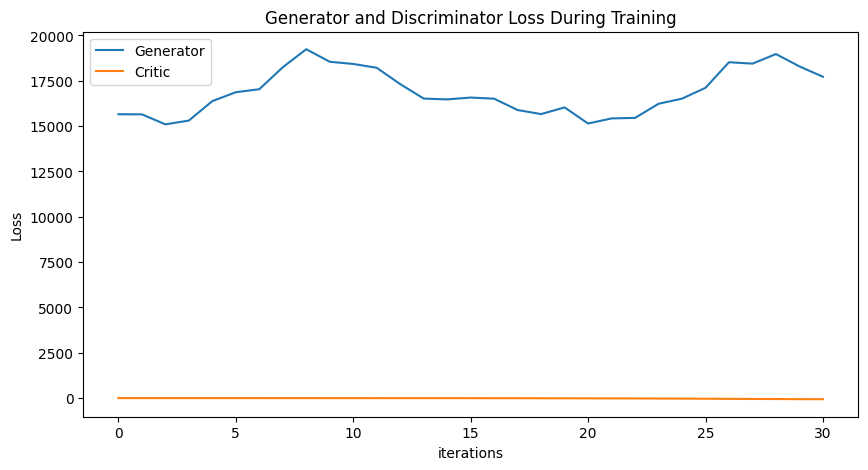

Epoch 40: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719]) Generator err ([0.027550339698791504, 0.030276959761977196, 0.029685450717806816, 0.005940358620136976, -0.02454068325459957, -0.1495654135942459, -0.19558824598789215, -

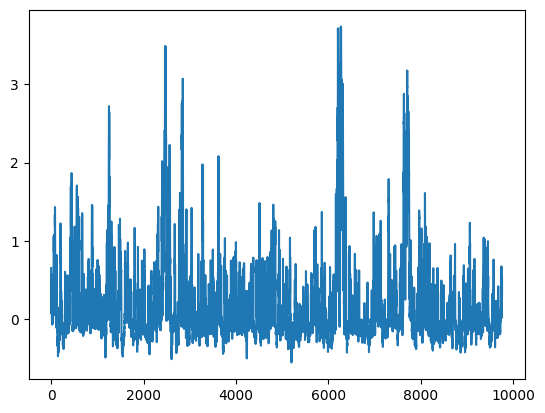

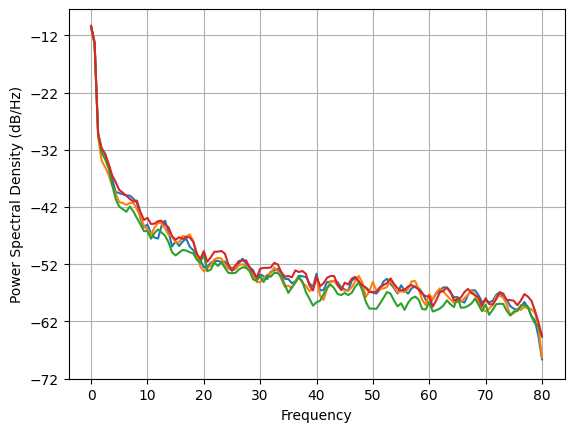

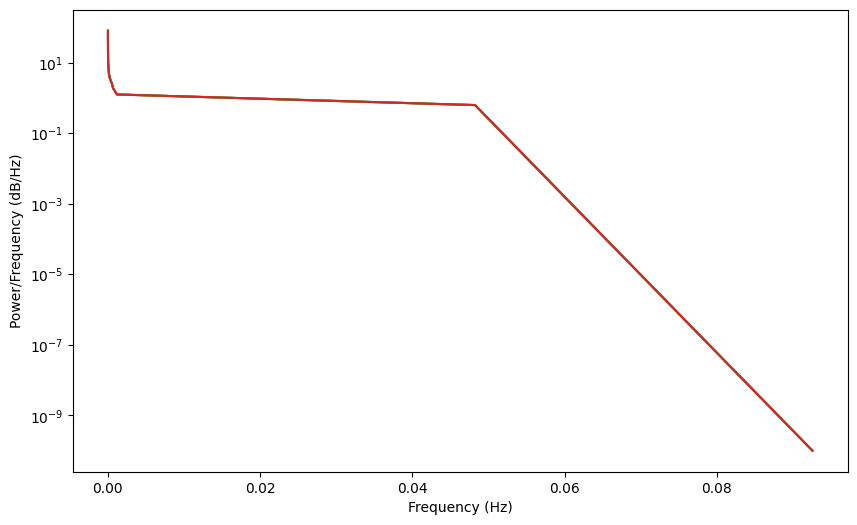

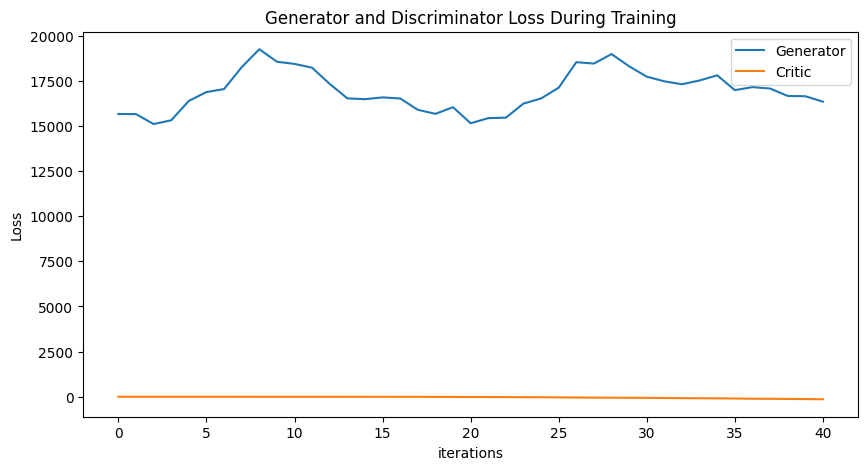

Epoch 50: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.358750268

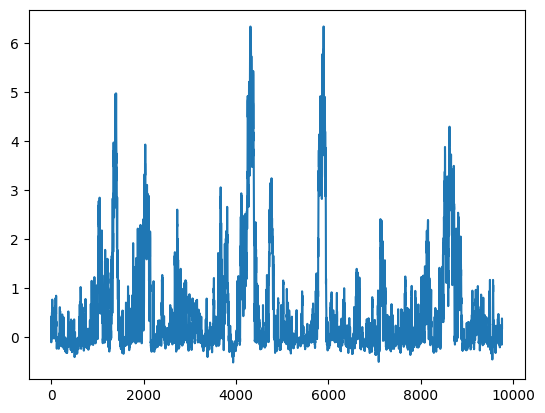

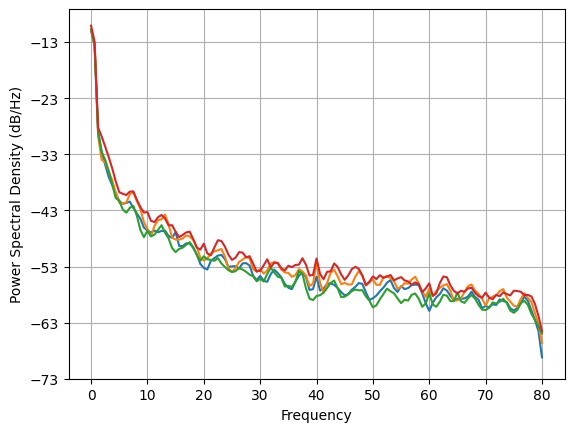

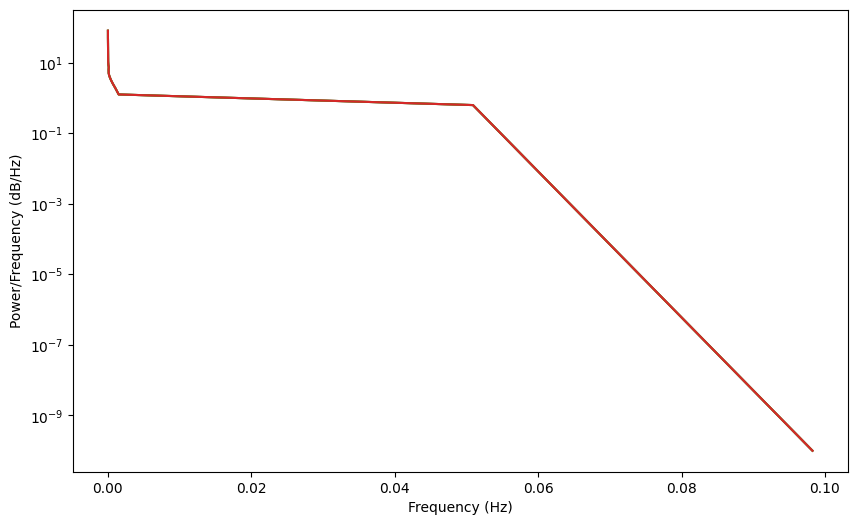

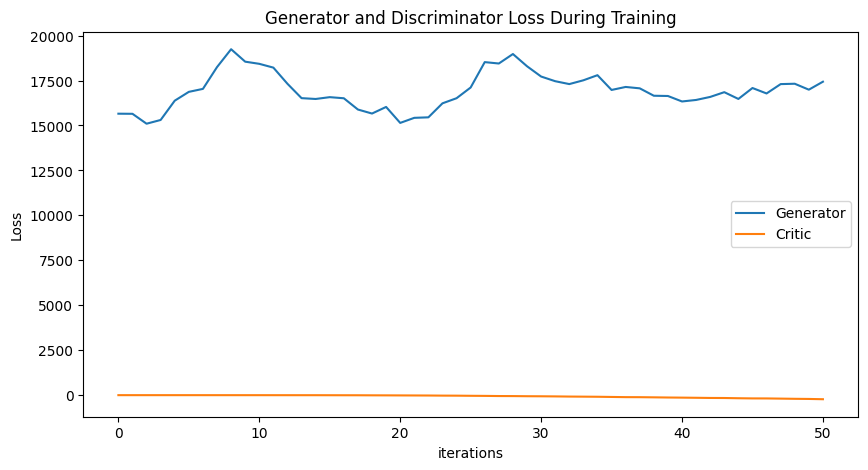

Epoch 60: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.358750268

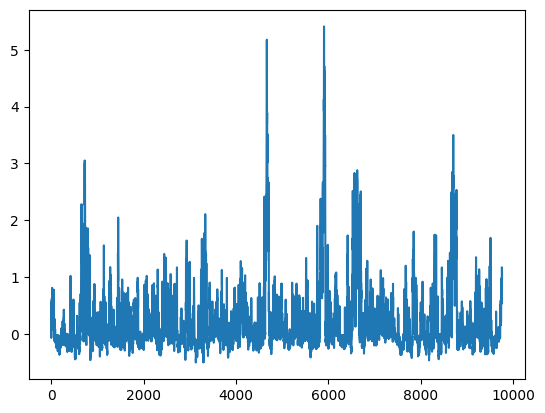

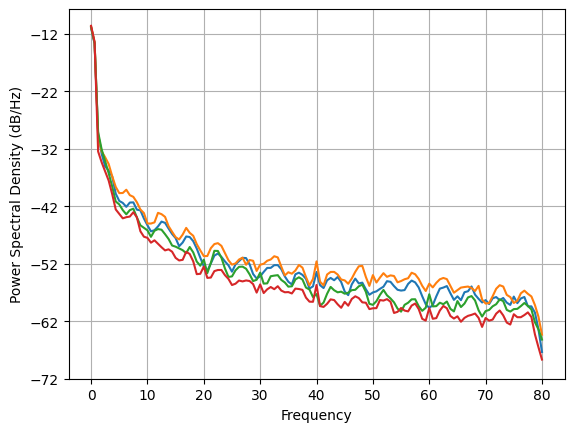

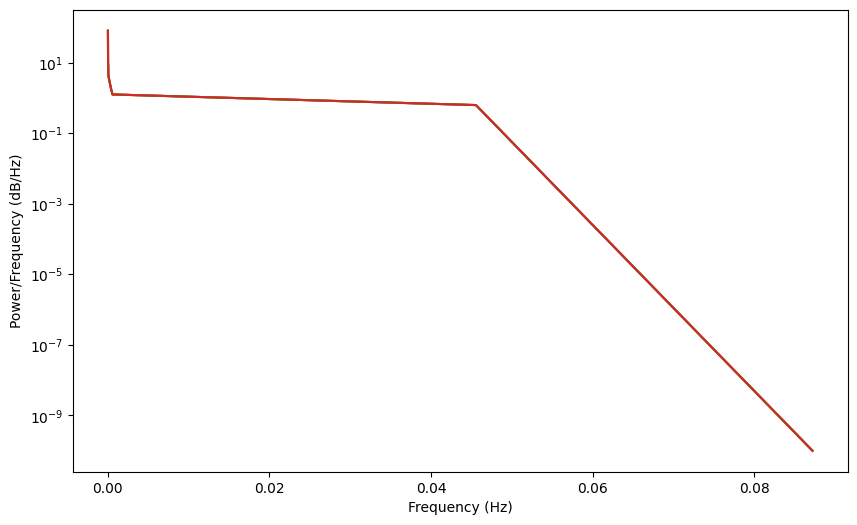

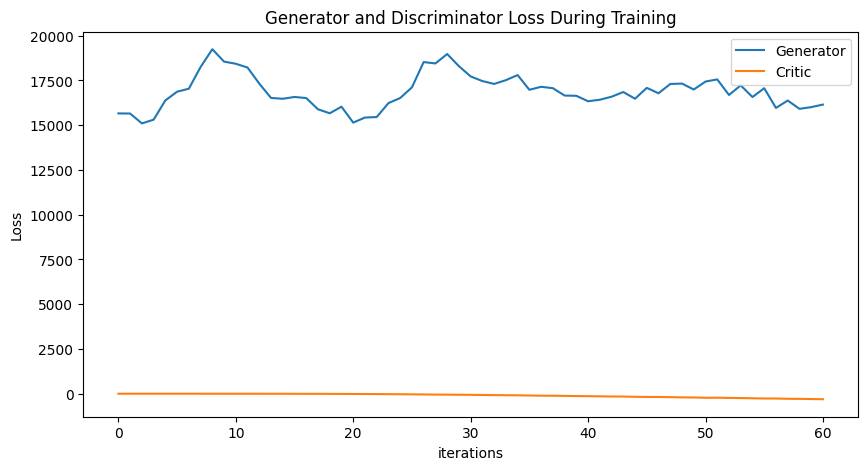

Epoch 70: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.358750268

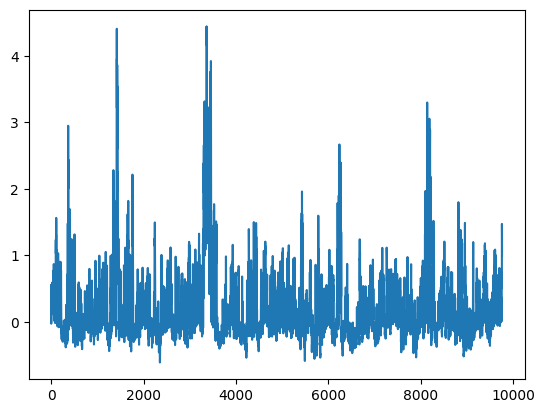

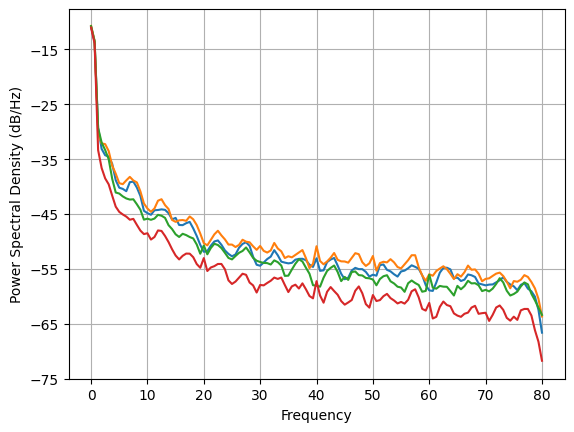

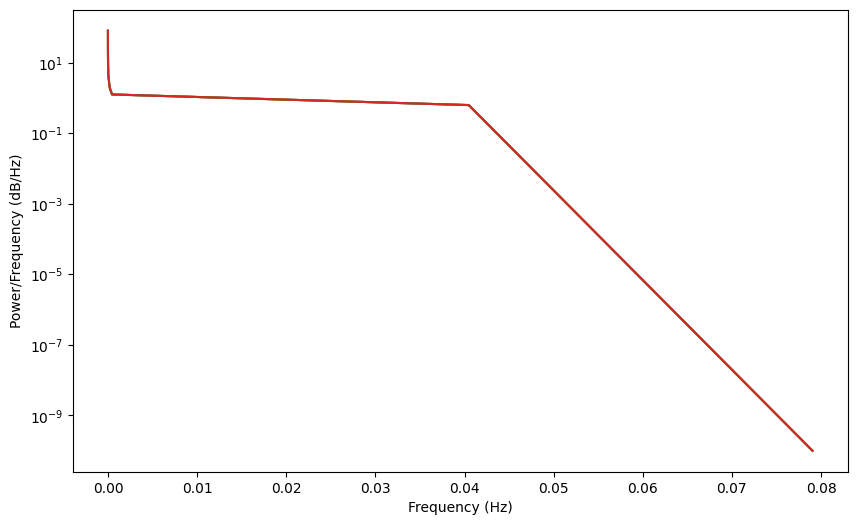

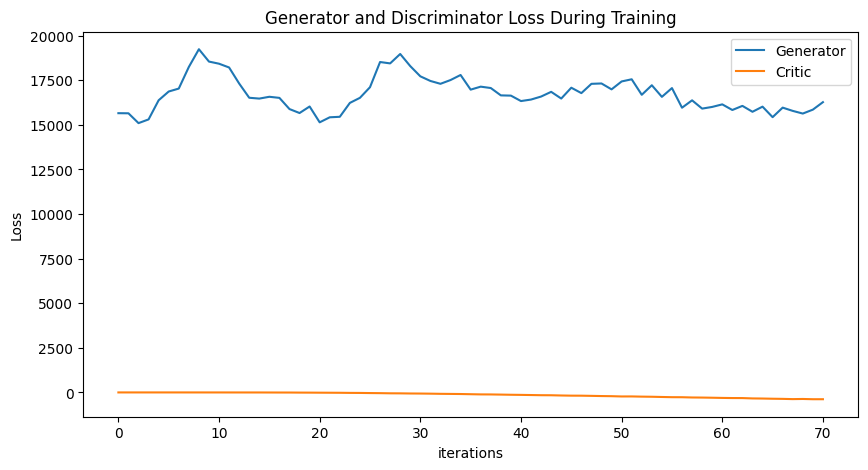

Epoch 80: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.358750268

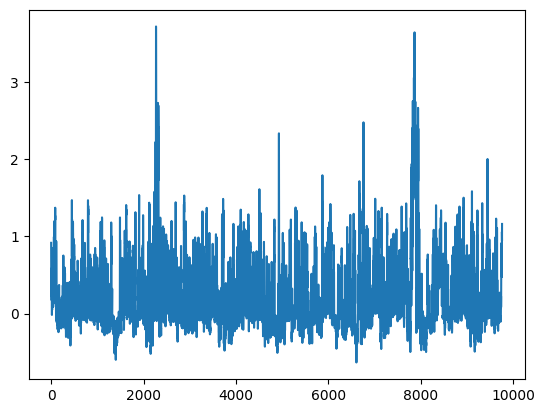

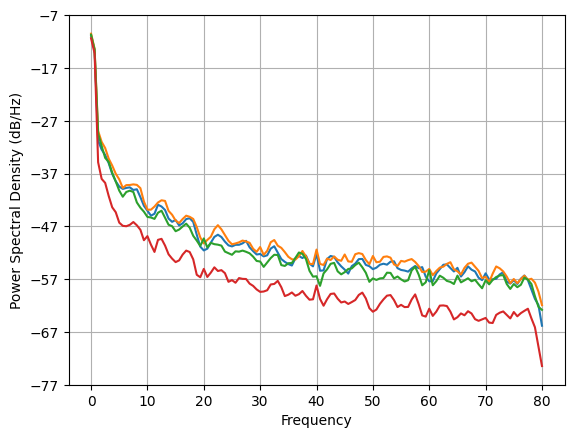

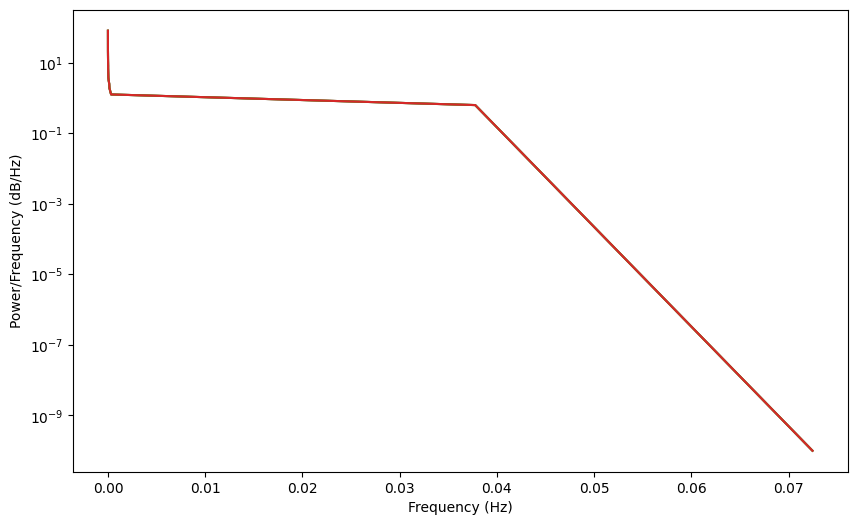

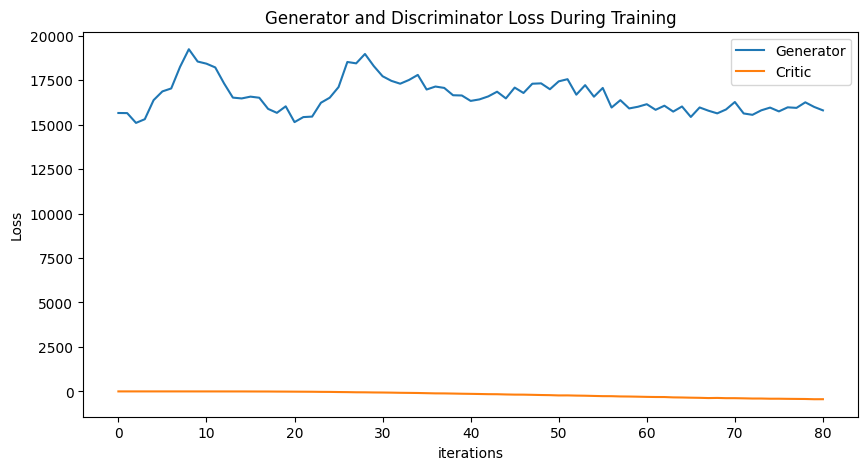

Epoch 90: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.358750268

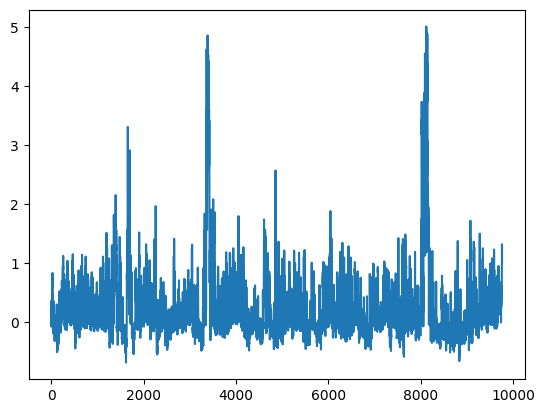

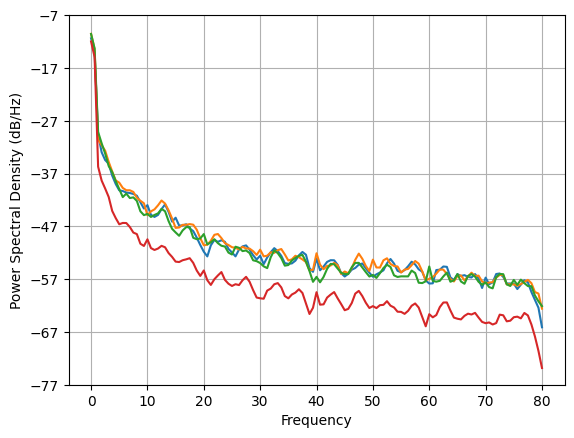

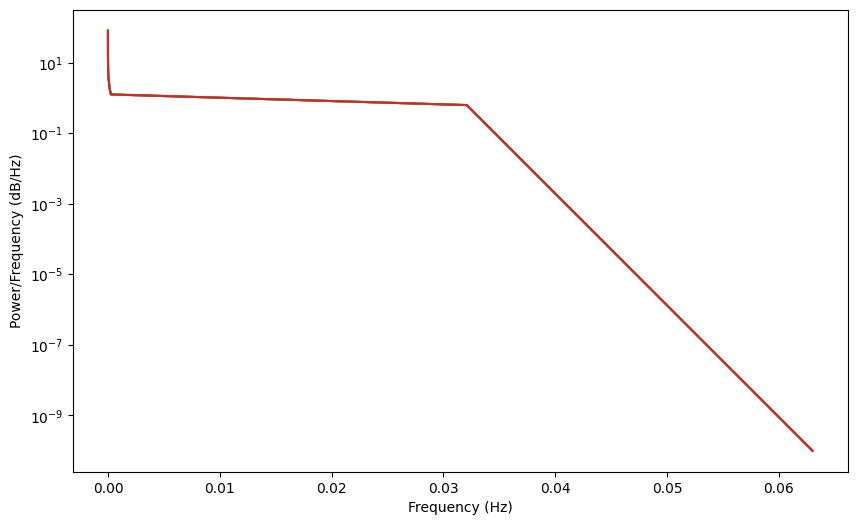

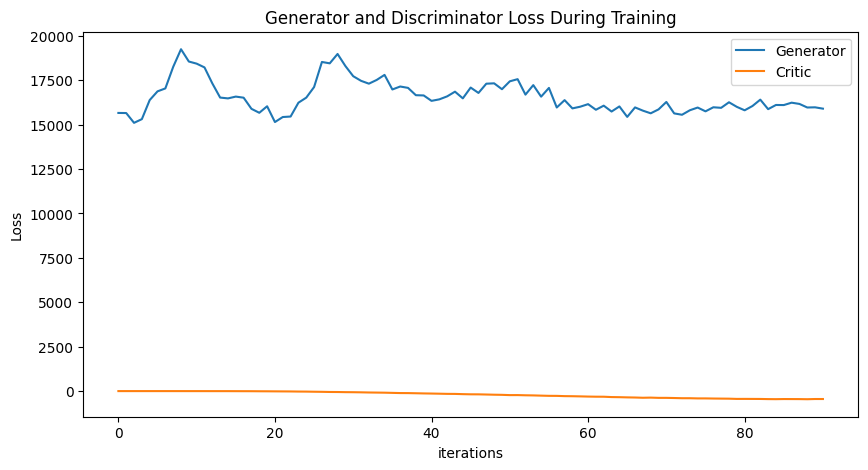

Epoch 100: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.35875026

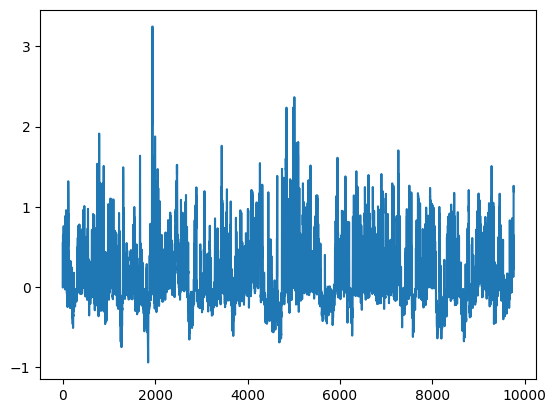

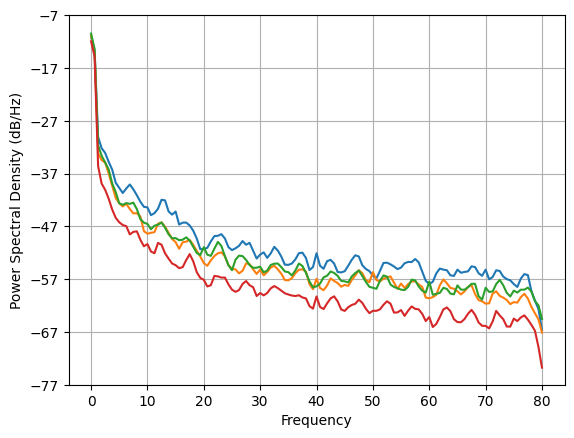

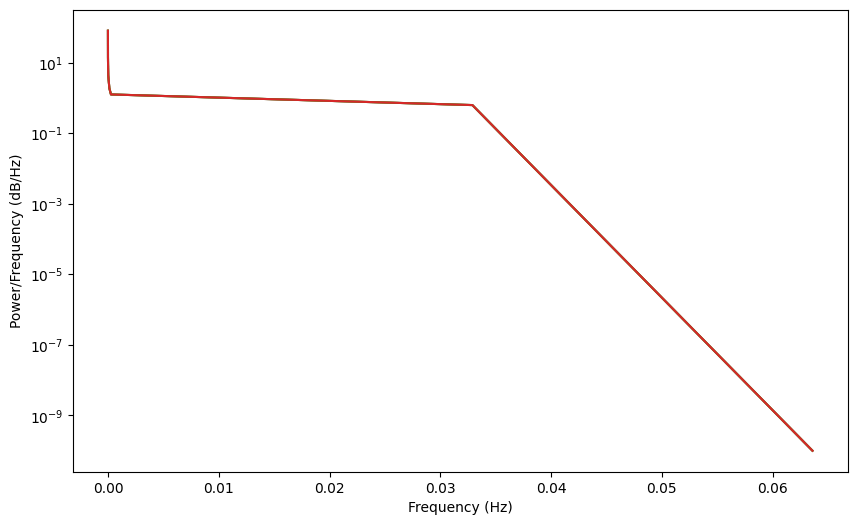

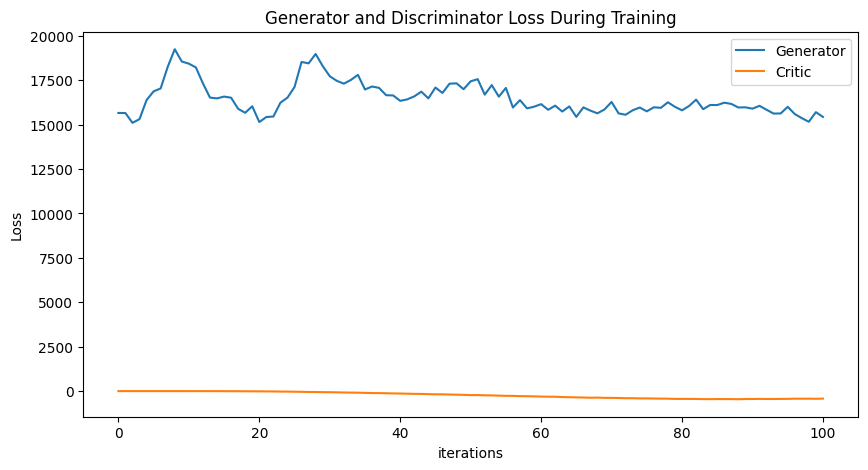

Epoch 110: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.35875026

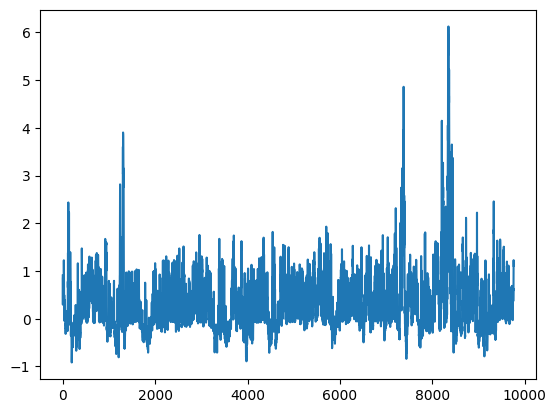

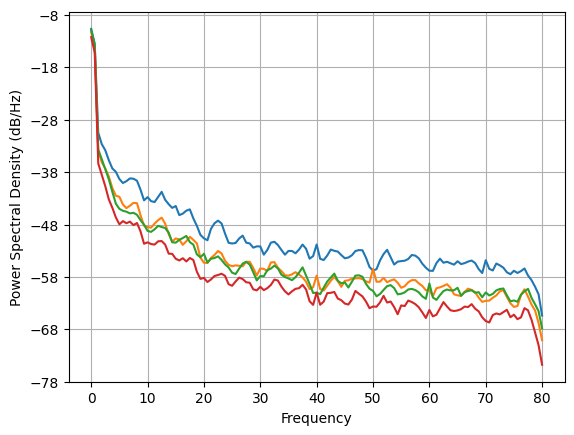

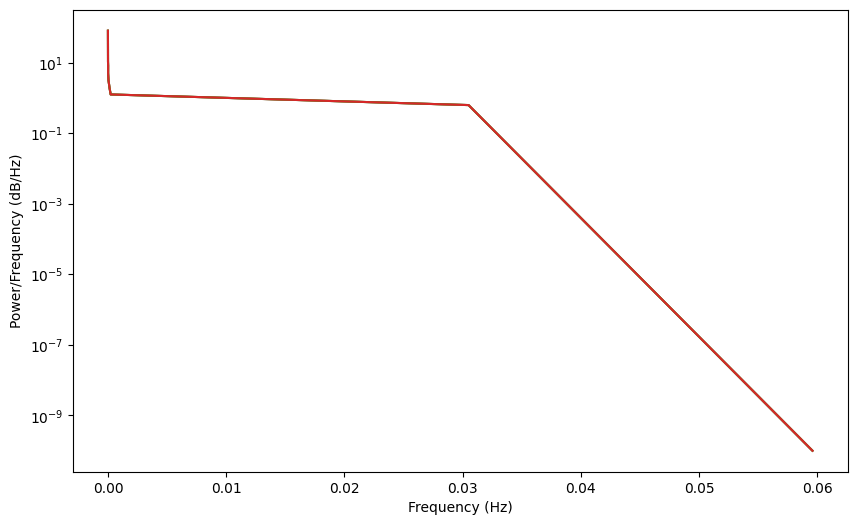

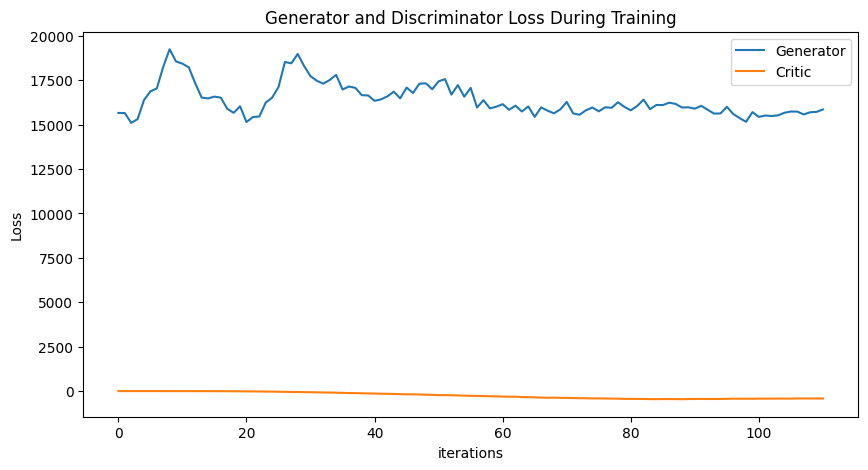

Epoch 120: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.35875026

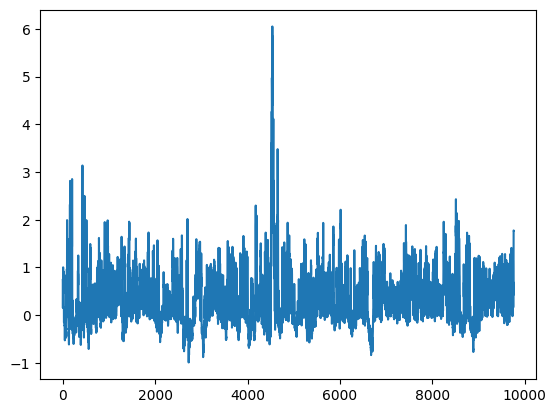

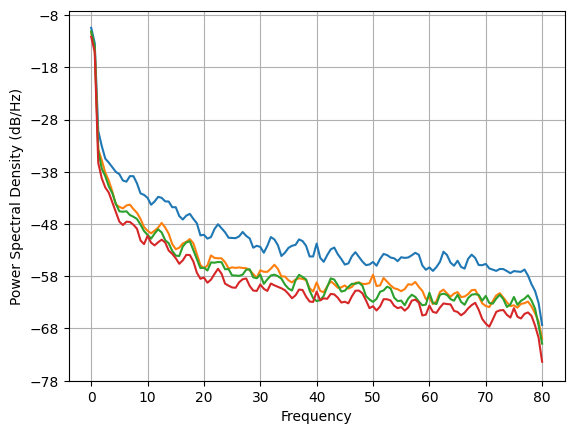

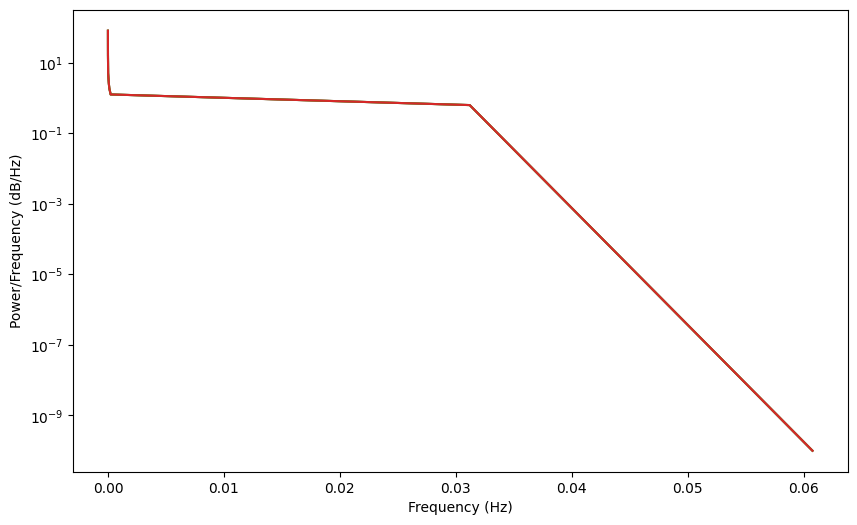

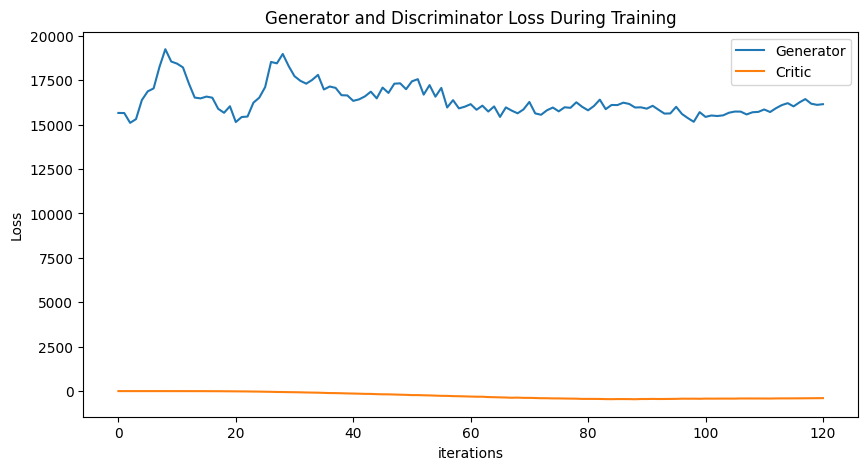

Epoch 130: Critic error ([15656.52517951649, 15650.466662330911, 15099.347580348443, 15307.647488619165, 16380.49052044201, 16871.364213016303, 17036.60888050054, 18248.061142520553, 19242.85786836324, 18550.172156691813, 18430.47932223647, 18219.11029051877, 17319.784120736505, 16521.366770957153, 16475.234740594344, 16576.441255189206, 16514.705830165483, 15887.877219095493, 15665.005532467721, 16032.013366958487, 15143.906486330918, 15426.251795435299, 15454.176259456484, 16233.159786344848, 16517.65173512317, 17113.76683166544, 18525.7475168334, 18448.09346664961, 18975.64828449555, 18295.63916272414, 17723.630497655176, 17463.873413421014, 17303.702848806213, 17514.34753282788, 17798.321099786197, 16977.091382804174, 17144.12890833507, 17066.922613330928, 16655.16035644873, 16641.208682048124, 16336.419289870719, 16421.033175364882, 16589.675630338712, 16853.68983241805, 16477.11935051584, 17084.919691326555, 16782.243681790747, 17302.36865260745, 17322.80485442122, 16992.35875026

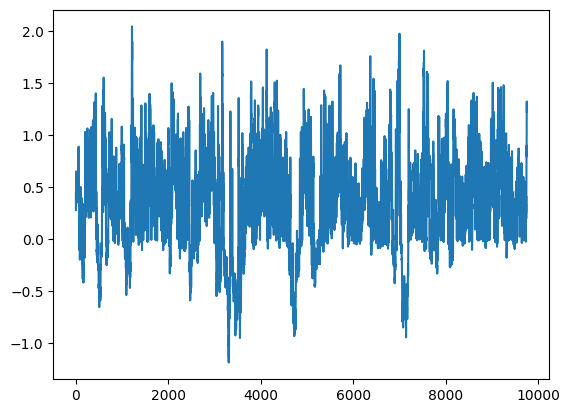

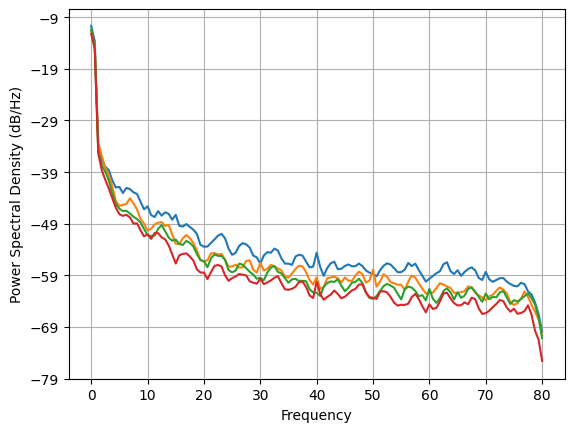

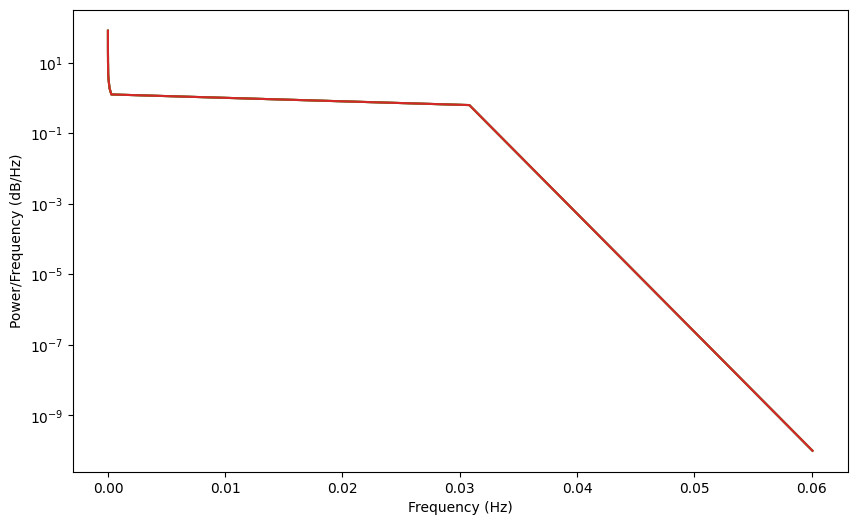

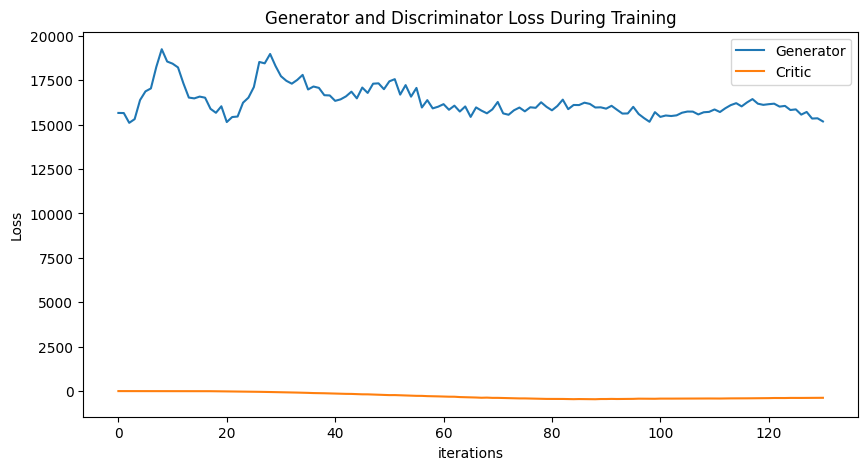

KeyboardInterrupt: 

In [20]:
SPECTRAL_FACTOR = 100
NUM_EPOCHS = 300
PRINT_INTERVAL = 10
BATCH_SIZE = 76 
train_loader = DataLoader(TensorDataset(torch.tensor(np.load("training-closed-4ch")).detach()), batch_size=BATCH_SIZE, shuffle=True)

def compute_psd_torch(data, fs, nperseg=256, noverlap=None):
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        fft_result = torch.fft.fft(data[ch_idx], n=nperseg // 2 + 1)
        Pxx = torch.abs(fft_result)**2
        psd[ch_idx] = torch.from_numpy(Pxx.detach().numpy() + 1e-10)

    return psd

def compute_psd_loss(real, fake):
    reals, fakes = [], []
    
    for btch in range(np.shape(real)[0]):
        psd_real = compute_psd_torch(real[btch], fs)
        reals.append(psd_real)

    for btch in range(np.shape(fake)[0]):
        psd_fake = compute_psd_torch(fake[btch], fs)
        fakes.append(psd_fake)
    reals, fakes = torch.tensor(reals), torch.tensor(fakes)

    # Normalize each sample independently
    psd_real = F.normalize(reals, p=2, dim=1)
    psd_fake = F.normalize(fakes, p=2, dim=1)

    psd_loss = ((psd_real - psd_fake)**2).mean()  # Check calculated PSD
    return psd_loss

def train():
    critic_err, gen_err, critic_psd_err, gen_psd_err = [], [], [], []
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=1e-5)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=1e-5)

    for epoch in range(NUM_EPOCHS):
        (real, ) = next(iter(train_loader))
        real.requires_grad = True

        for _ in range(5):
            fake = G(sample_normal_distribution(BATCH_SIZE, 200, 305))
            critic_real = D(real).reshape(-1)
            critic_fake = D(fake).reshape(-1)
            D.zero_grad()            
            loss_critic_psd = compute_psd_loss(real.detach(), fake.detach()) * SPECTRAL_FACTOR
            loss_critic = -torch.mean(critic_real) + torch.mean(critic_fake) + (gradient_penalty(D, real, fake) * LAMBDA_GP) + loss_critic_psd
            loss_critic.backward()
            critic_optimizer.step()  

        fake = G(sample_normal_distribution(BATCH_SIZE, 200, 305))
        gen_fake = D(fake).reshape(-1)
        G.zero_grad()
        loss_gen = -torch.mean(gen_fake)
        loss_gen.backward()
        gen_optimizer.step()
        
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())
        critic_psd_err.append(loss_critic_psd.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            print("Epoch %s: Critic PSD error (%s)" % (epoch, critic_psd_err))
            plot_everything(fake, critic_err, gen_err)

    return critic_err, gen_err, fake, D, G

critic_err, gen_err, generated, disc, gen = train()

torch.save(gen, 'generator-v12-2.pt')
torch.save(disc, 'discriminator-v12-2.pt')
np.save('closed-v12-2.npy', generated.detach())
plot_everything(generated, gen_err, critic_err)
generated_data_closed = None